In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import unidecode



elevation data source
* https://datacatalog.worldbank.org/search/dataset/0037910

coastal created manually in QGIS

population density data source
* https://hub.worldpop.org/geodata/summary?id=46241



## Elevation

In [ ]:
import geopandas as gpd
from rasterstats import zonal_stats

zones = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/Brazil/clean_shp.shp"
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/elevation/ELE.tif"

gdf = gpd.read_file(zones)

stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["mean"]))
gdf = gdf.join(stats)


In [81]:
len(gdf['adm1'].unique())

27

In [ ]:
gdf.rename(columns = {'mean':'mean_elev'}, inplace=True)

Text(0.5, 1.0, 'Average elevation (m.a.s.l.) in Brazilian districts')

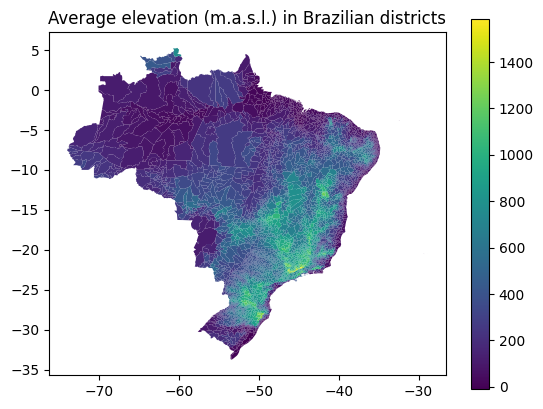

In [83]:
gdf.plot(column='mean_elev', legend=True )
plt.title("Average elevation (m.a.s.l.) in Brazilian districts")

In [84]:
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']

## Coastal

In [85]:
coast = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/coastline.shp')

In [86]:

coast.rename(columns={'ADM1_PT': 'adm1', 'ADM2_PT': 'adm2'}, inplace=True)
coast['adm2'] = coast['adm2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
coast['adm1'] = coast['adm1'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')



In [87]:
coast['location'] = coast['adm2'] + ', ' + coast['adm1']

In [88]:
gdf['coast'] = [1 if x in coast['location'].unique() else 0 for x in gdf['location']]

<AxesSubplot:>

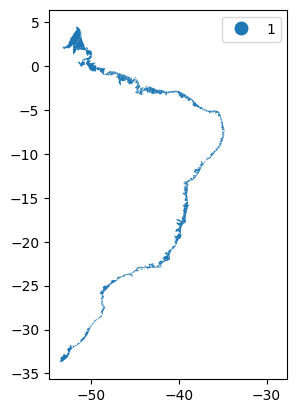

In [89]:
gdf[gdf['coast'] == 1].plot(column='coast', categorical= True, legend=True)

## Human Development Index

In [90]:
import pandas as pd

In [91]:
hdi = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/brazil/GDL-Subnational-HDI-data.csv')

In [92]:
hdi.rename(columns={'2021':'HDI', 'Region': 'adm1'}, inplace=True)

In [93]:
gdf = gdf.merge(hdi[['adm1', 'HDI']], on='adm1')

In [94]:
len(gdf['adm1'].unique())

27

Text(0.5, 1.0, 'Provincial HDI Brazil')

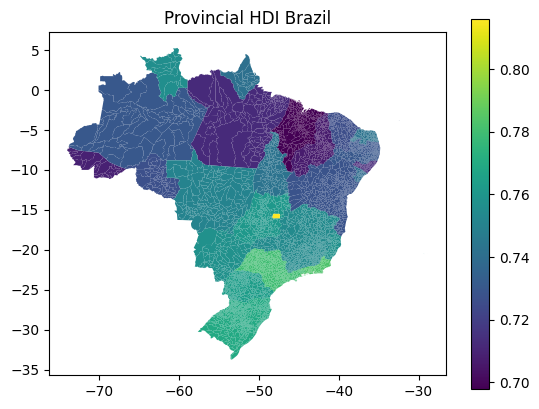

In [95]:
gdf.plot(column='HDI', legend=True)
plt.title('Provincial HDI Brazil')

## Population density

In [96]:
values = "/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/brazil/popdens/bra_pd_2020_1km_UNadj.tif"


stats = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["min", "max", "mean"]))
gdf = gdf.join(stats)


In [97]:
gdf.rename(columns={'mean':'popdens', 'ADM0_EN':'adm0'}, inplace=True)

In [98]:
gdf = gdf[['adm0', 'adm1', 'adm2', 'geometry', 'mean_elev', 'location', 'coast', 'HDI', 'popdens']]

## Age

In [99]:
import glob

In [100]:
gdf['over60_pop'] = 0
for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/brazil/age/*'):
    
    values = file
    
    pop_total = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['over60_pop'] += pop_total['sum']




In [101]:
for file in glob.glob('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/demographic/brazil/pop/*'):
    
    values = file
    
    pop_sum = gpd.GeoDataFrame(zonal_stats(gdf, values, stats=["sum"]))
    gdf['pop_total'] = pop_sum['sum']

In [102]:
gdf['over60_propor'] = gdf['over60_pop'] / gdf['pop_total']

Text(0.5, 1.0, 'Age 60+ population proportion')

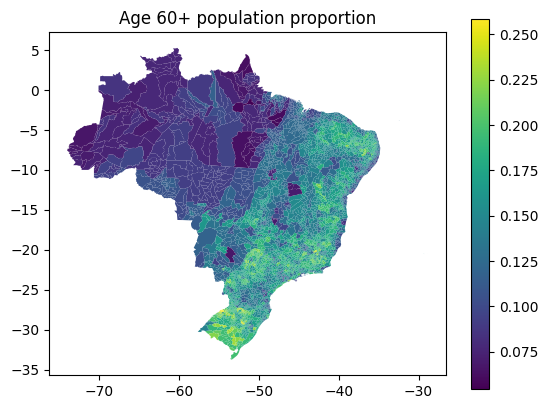

In [103]:
gdf.plot(column='over60_propor', legend=True)
plt.title("Age 60+ population proportion")

In [104]:
HDI_subset = gdf.drop_duplicates('HDI')

In [105]:
deciles = pd.qcut(HDI_subset['HDI'], 10, labels= range(1,11)).astype(int)

In [106]:
HDI_subset['HDI_dec'] = deciles

/Users/shivyucel/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [107]:
gdf = gdf.merge(HDI_subset[['HDI', 'HDI_dec']], on='HDI')

In [108]:
gdf.dropna(subset='over60_pop', inplace=True)

In [109]:
gdf['popdens_dec'] = pd.qcut(gdf['popdens'], 10, labels= range(1,11)).astype(int)
gdf['over60_dec'] = pd.qcut(gdf['over60_propor'], 10, labels= range(1,11)).astype(int)


In [111]:
gdf

,adm0,adm1,adm2,geometry,mean_elev,location,coast,HDI,popdens,over60_pop,pop_total,over60_propor,HDI_dec,popdens_dec,over60_dec
0,Brazil,Rondonia,Alta Floresta D'Oeste,"POLYGON ((-62.04950 -11.86731, -62.04559 -11.8...",246.759281,"Alta Floresta D'Oeste, Rondonia",0,0.727,3.109231,1955.255890,1.832961e+04,0.106672,3,1,1
1,Brazil,Rondonia,Ariquemes,"POLYGON ((-62.42279 -9.80481, -62.42688 -9.806...",165.551436,"Ariquemes, Rondonia",0,0.727,24.118446,9020.859131,1.052535e+05,0.085706,3,5,1
2,Brazil,Rondonia,Cabixi,"POLYGON ((-60.37329 -13.40887, -60.37323 -13.4...",225.451552,"Cabixi, Rondonia",0,0.727,3.863980,364.792162,3.419754e+03,0.106672,3,1,1
3,Brazil,Rondonia,Cacoal,"POLYGON ((-61.00061 -10.99219, -61.00061 -11.0...",230.038667,"Cacoal, Rondonia",0,0.727,21.526147,9038.257935,7.870890e+04,0.114831,3,5,2
4,Brazil,Rondonia,Cerejeiras,"POLYGON ((-61.20642 -13.08759, -61.20282 -13.0...",193.177738,"Cerejeiras, Rondonia",0,0.727,5.622252,1575.516037,1.476972e+04,0.106672,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,Brazil,Goias,Vianopolis,"POLYGON ((-48.25983 -16.73871, -48.25989 -16.7...",909.171109,"Vianopolis, Goias",0,0.761,14.287214,2321.866051,1.333636e+04,0.174100,8,4,7
5568,Brazil,Goias,Vicentinopolis,"MULTIPOLYGON (((-49.94391 -17.60071, -49.94800...",563.796667,"Vicentinopolis, Goias",0,0.761,12.064917,1442.378883,8.831594e+03,0.163320,8,3,6
5569,Brazil,Goias,Vila Boa,"POLYGON ((-47.10931 -14.67590, -47.10419 -14.6...",572.608255,"Vila Boa, Goias",0,0.761,6.292424,598.331921,5.791113e+03,0.103319,8,2,1
5570,Brazil,Goias,Vila Propicio,"POLYGON ((-48.61108 -15.00250, -48.60809 -15.0...",670.152421,"Vila Propicio, Goias",0,0.761,2.646543,815.556446,5.725692e+03,0.142438,8,1,4


In [112]:
gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/merged.shp')

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_64781/1727657506.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/brazil/merged.shp')
